In [110]:
import ast
from datetime import datetime
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from mlxtend.plotting import plot_decision_regions

import numpy as np

import pandas as pd
# pd.options.display.max_columns = None
# pd.set_option('display.max_rows', 500)

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import seaborn as sns

import re

from sklearn import datasets
from sklearn.ensemble import( AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, 
                              GradientBoostingClassifier,RandomForestClassifier,RandomForestRegressor, StackingClassifier )

from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import( KNNImputer, SimpleImputer )
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import( LogisticRegression, LinearRegression, Ridge, Lasso )
from sklearn.model_selection import( cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split )
from sklearn.metrics import( accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             explained_variance_score, f1_score,mean_absolute_error, mean_absolute_percentage_error, 
                             mean_squared_error, plot_confusion_matrix, r2_score, RocCurveDisplay)
                             
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import ( DecisionTreeClassifier, DecisionTreeRegressor )
from sklearn import tree
from sklearn.utils import resample

from scipy.stats import mode 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import warnings
warnings.filterwarnings( "ignore", category=DeprecationWarning ) # to avoid deprecation warnings

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template( layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6",
                                                              "#2A7FAF", "#23B1AB", "#0E3449", "#015955"] )
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JUPITER or "iframe_connected" or "notebook"

from xgboost import XGBRegressor

In [111]:
dataset = pd.read_csv('src/get_around_pricing_project_clean.csv')
dataset.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,227832,120,diesel,black,estate,True,False,False,False,False,False,True,73
1,Peugeot,108245,100,diesel,brown,estate,True,True,True,False,False,False,True,108
2,Renault,221018,135,diesel,black,estate,True,True,False,True,True,False,True,128
3,Peugeot,101658,100,diesel,grey,estate,False,True,False,False,False,False,True,107
4,Citroën,163181,120,diesel,grey,estate,False,False,False,False,False,False,True,91


## Séparation Variables explicative X et variable Cible/Target Y 

In [112]:
target_name = 'rental_price_per_day'

Y = dataset[:][target_name]
X = dataset.drop(columns= [target_name])

## Séparation en Entrainement & Test 

In [113]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

## Préprocessing Pipeline

In [114]:
# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur

print(f'numeric_features : {numeric_features}')
print(f'categorical_features : {categorical_features}')

numeric_features : Index(['mileage', 'engine_power'], dtype='object')
categorical_features : Index(['model_key', 'fuel', 'paint_color', 'car_type'], dtype='object')


## Training Model
### Random Forest model : Grid search

In [115]:
model = RandomForestRegressor()

# Grid of values to be tested
params = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [40, 60, 80, 100]
}
gridsearch = GridSearchCV(model, param_grid = params, cv = 3, n_jobs=-1) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [40, 60, 80, 100]})

In [116]:
print(f'best estimator : {gridsearch.best_estimator_}')
print(f'best score : {gridsearch.best_score_}')
print(f'best parameters : {gridsearch.best_params_}')

Y_pred= gridsearch.predict(X_test)

# https://stackoverflow.com/questions/50789508/random-forest-regression-how-do-i-analyse-its-performance-python-sklearn
print('Mean Absolute Error (MAE):', mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error (MSE):', mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(Y_test, Y_pred)))
print('Mean Absolute Percentage Error (MAPE):', mean_absolute_percentage_error(Y_test, Y_pred))
print('Explained Variance Score:', explained_variance_score(Y_test, Y_pred))

print("R2 score : ", r2_score(Y_test, Y_pred))

best estimator : RandomForestRegressor(max_depth=12, min_samples_split=4, n_estimators=40)
best score : 0.7212121736154463
best parameters : {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 40}
Mean Absolute Error (MAE): 9.232147729809853
Mean Squared Error (MSE): 162.25870365007577
Root Mean Squared Error (RMSE): 12.73808084642564
Mean Absolute Percentage Error (MAPE): 0.0818299793862688
Explained Variance Score: 0.7762726954778303
R2 score :  0.7762584350547627


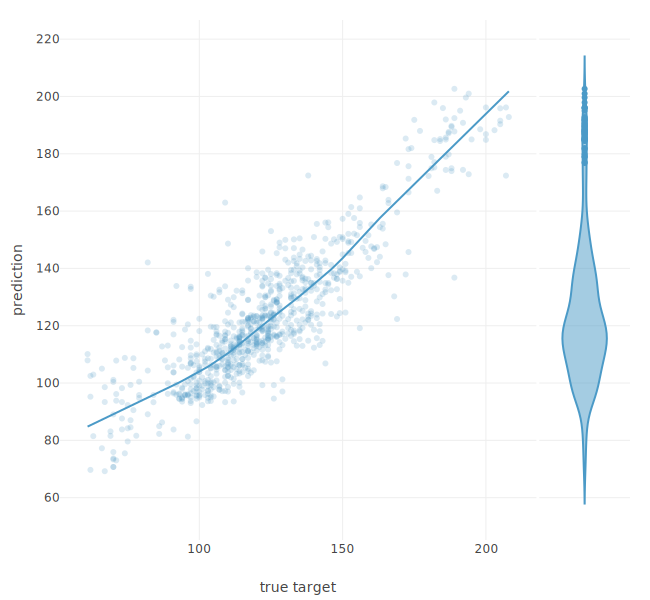

In [117]:
fig = px.scatter(x = Y_test, y = Y_pred, opacity=0.2, 
                 trendline="lowess", width=650, height=600, marginal_y='violin',
                 labels={
                     "x": "true target",
                     "y": "prediction"
                 },)
fig.update_layout( margin=dict(l=60, r=20, t=20, b=60), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

## Feature importance
### Reverse Encoding

In [118]:
#calculate coefficient features
list_features = []
list_num = [] # preprocessor num
list_cat = [] # preprocessor cat

for column in X.columns:
    if column in categorical_features:
        if len(column) == 0:
            pass
        elif len(column) == 1:
            list_cat.append(f'{column} : {X[column]}')
        else:
            feactures = sorted(X[column].unique().tolist())
            feactures = feactures[1:]
            for feacture in feactures:
                list_cat.append(f'{column} : {feacture}')
        
    else:
        list_num.append(column)

list_features = list_num + list_cat

##################

list_classification = []

for categorie in Y.unique():
    list_classification.append(f'{target_name} : {categorie}')

## Feature importance
### Plot Tree

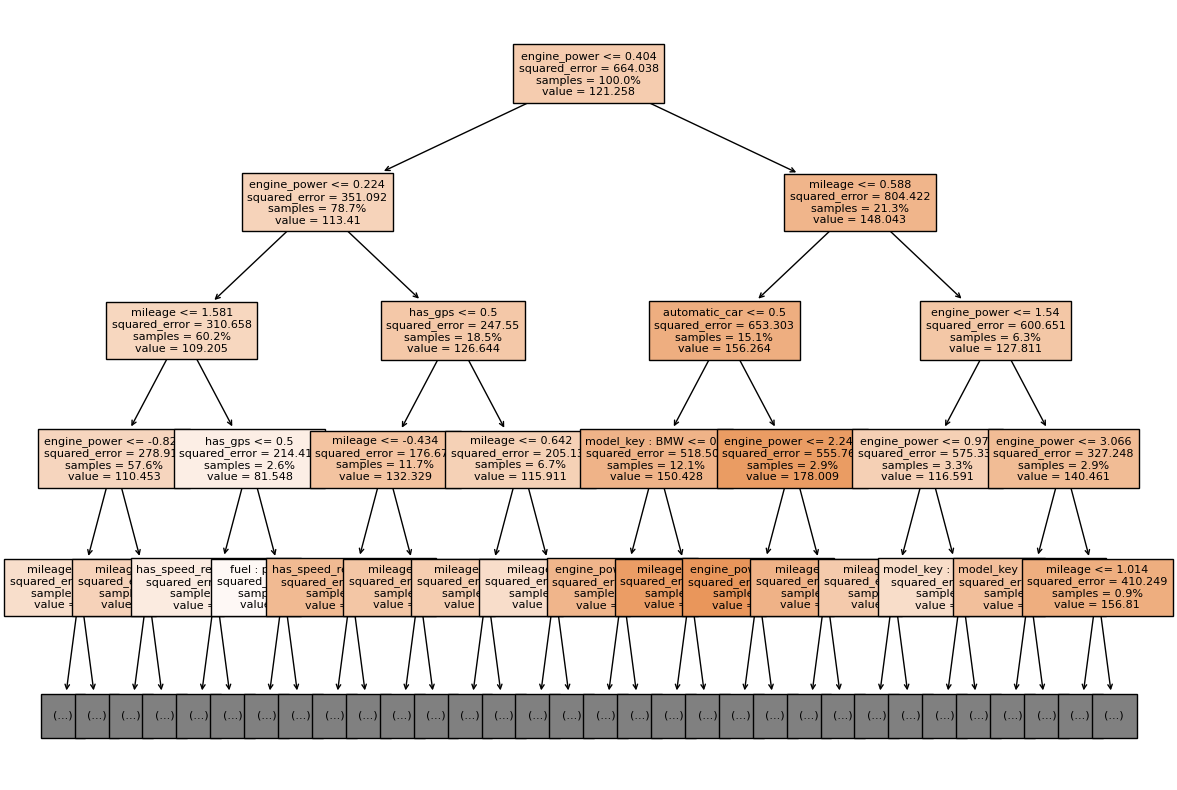

In [119]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
plt.figure(figsize=(14,10))
tree.plot_tree(gridsearch.best_estimator_.estimators_[1], filled=True, 
               fontsize=8, max_depth= 4, proportion=True,
               feature_names=list_features,
               class_names=list_classification);